<a href="https://colab.research.google.com/github/Farhanramazainn/FarhanR_MachLearn/blob/main/FarhanR_MachLearn_Week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NAMA : FARHAN RAMAZAIN

KELAS : TI - 3G

NIM : 2141720209

Link GitHub :

**Job Sheet 10 : Recurrent Neural Network (RNN)**

**PRAKTIKUM 1**

RNN untuk Analisis Sentimen

Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Being S Club Seven, the film already boosts an ecstatic atmosphere! But seriously, Oprah has a point when claiming: "Don\'t go there, girl!" Spice World suddenly doesn\'t seem to be all that bad... I take my money elsewhere!'
 b'This is without a doubt the funniest of the Curly stooges shorts. I\'ve seen it dozens of times and it always makes me laugh. Hilarious pantomime sequences. A perfect example of "musical comedy". Even people who don\'t like the knuckleheads remember this one fondly.'
 b"Not very impressed. Its difficult to offer any spoilers to this film, because there is almost no development in the plot. Everything becomes clear in the first ten minutes and from there on its like watching paint dry. The acting seems very poor as well, and reminds me of the old black and white Maoist era films shown occasionally on daytime Chinese television. Although this is difficult to tell with the female role, Yuwen, as the story seems to only require her walking round like a w

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[107,   1,   1, ...,   0,   0,   0],
       [ 11,   7, 201, ...,   0,   0,   0],
       [ 22,  53,   1, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Being S Club Seven, the film already boosts an ecstatic atmosphere! But seriously, Oprah has a point when claiming: "Don\'t go there, girl!" Spice World suddenly doesn\'t seem to be all that bad... I take my money elsewhere!'
Round-trip:  being [UNK] [UNK] [UNK] the film already [UNK] an [UNK] atmosphere but seriously [UNK] has a point when [UNK] dont go there girl [UNK] world [UNK] doesnt seem to be all that bad i take my money [UNK]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

**Buat Model**

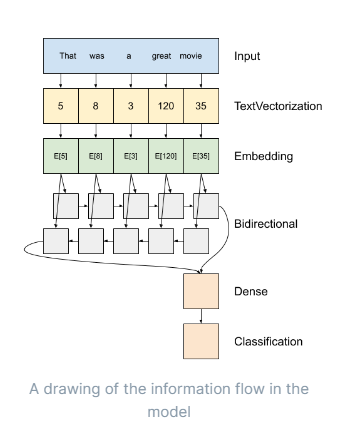

diagram model dapat dilihat pada gambar diatas

1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

 -Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

 -Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [16]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00713544]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 431ms/step
[0.00713544]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 158s 405ms/step - loss: 0.3208 - accuracy: 0.8564
Test Loss: 0.3208307921886444
Test Accuracy: 0.8564000129699707


(0.0, 0.6555852189660072)

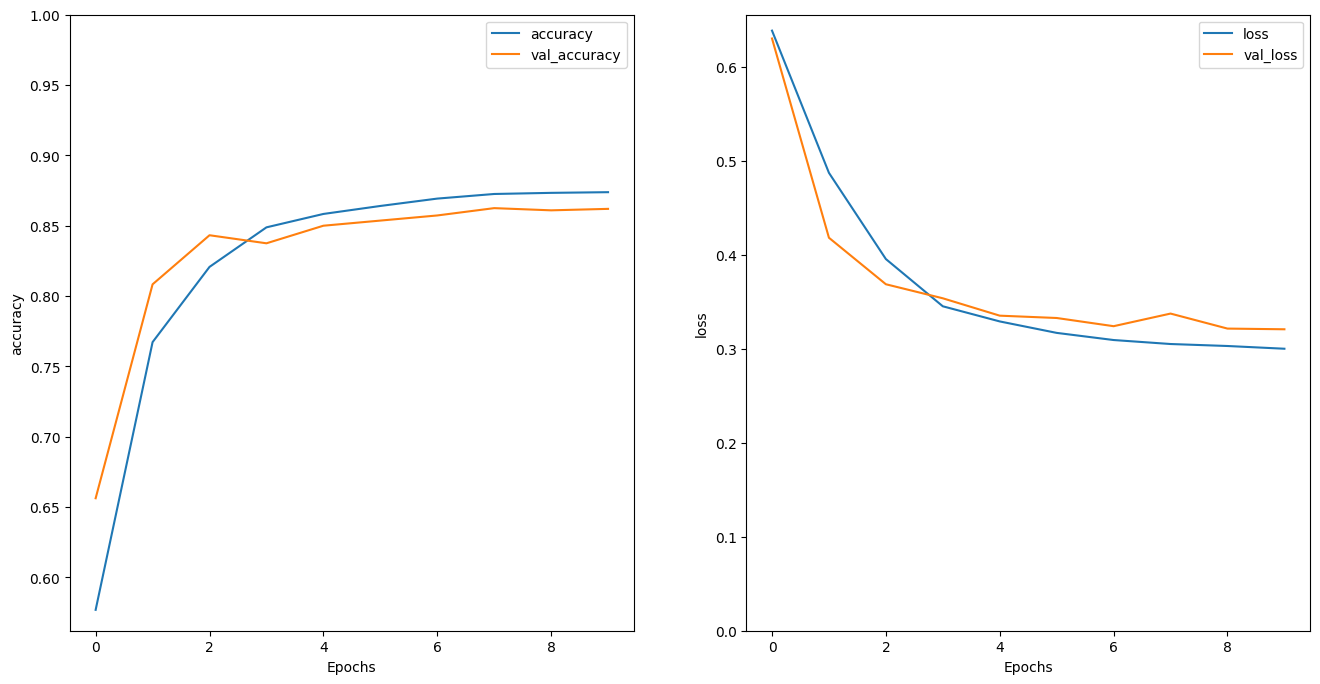

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [25]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


**Stack two or more LSTM layers**

In [27]:
model = tf.keras.Sequential([
     encoder,
     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1)
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 315s 790ms/step - loss: 0.6932 - accuracy: 0.5000
Test Loss: 0.6931748986244202
Test Accuracy: 0.5


In [31]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 11s 11s/step
[[-0.00111991]]


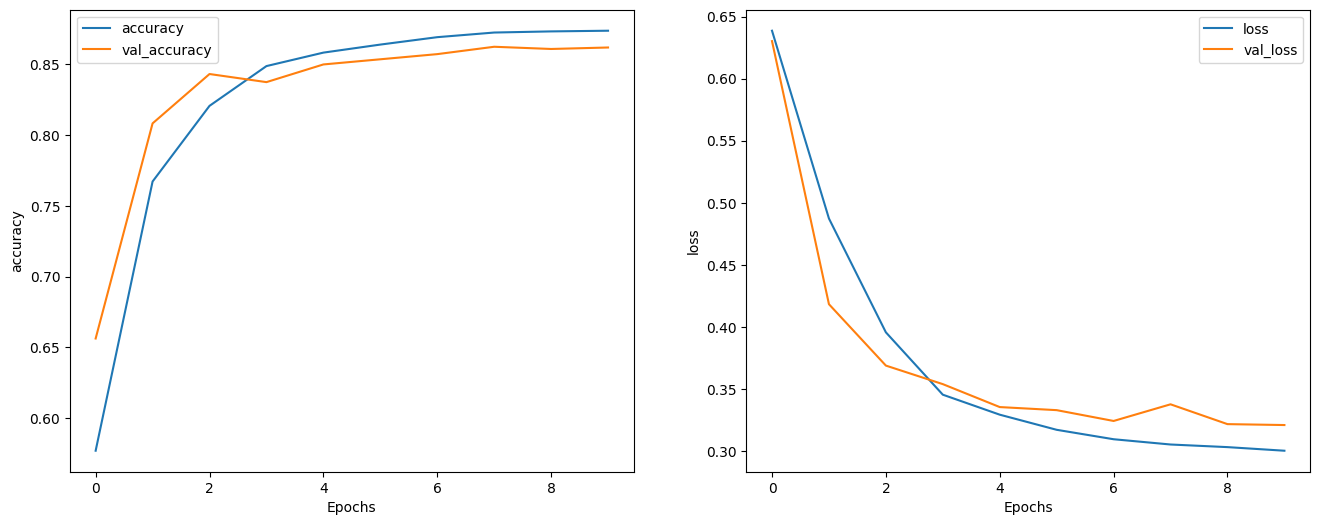

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**Praktikum 2**

**Generator Teks dengan RNN**

Setup

Import TensorFlow

In [33]:
import tensorflow as tf
import numpy as np
import os
import time

In [34]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [35]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [36]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [37]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks
Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [38]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [39]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [40]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode

In [41]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [42]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [43]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [44]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

**Membuat Trianing Set dan Target**

In [45]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [46]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [47]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [48]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [49]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [50]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [51]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [52]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [55]:
dataset = sequences.map(split_input_target)

In [56]:
for input_example, target_example in dataset.take(1):
 print("Input :", text_from_ids(input_example).numpy())
 print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [57]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Membuat Model**

In [58]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [59]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [60]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [61]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [62]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [64]:
sampled_indices

array([43, 23, 17, 42, 37, 41,  7, 46, 48, 53,  2, 62, 64,  8, 17, 30,  1,
       44, 58,  7, 44,  0, 16, 11, 63, 49, 22, 56, 23, 22, 22, 52, 63, 50,
        1, 37, 33, 24, 63, 55, 50, 49, 17,  6, 22, 34, 19, 12, 49, 31, 14,
        4,  3, 14, 48, 20, 40, 52, 11, 11, 39, 14, 16, 14, 18, 56, 31, 20,
       51, 40, 41, 44, 63, 14, 25, 58, 45, 64, 13, 35, 65, 19, 25, 11, 52,
       23, 52, 30, 51, 49,  2, 23,  7, 54, 32, 27, 23, 10, 16, 40])


Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [65]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"ack him hence with distaffs.\nYet of your royal presence I'll adventure\nThe borrow of a week. When at"

Next Char Predictions:
 b"dJDcXb,gin wy-DQ\nes,e[UNK]C:xjIqJIImxk\nXTKxpkjD'IUF;jRA$!AiGam::ZACAEqRGlabexALsfy?VzFL:mJmQlj J,oSNJ3Ca"


**Train Model**

Tambahan optimizer dan fungsi loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [66]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [67]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1889787, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [68]:
tf.exp(example_batch_mean_loss).numpy()

65.95539

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [69]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:



In [70]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [71]:
EPOCHS = 10

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

**Generate Teks**

Berikut ini membuat prediksi satu langkah:

In [73]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [74]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [75]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:LyXt?iGVw
d.mH;oYAjZnADEX'T:lVj.qIV't$Xd&S?GrAupfE:rMoJOeQ!C ng!npZSiMep bkq;DQcc&xNmwiBhXpQaMcXYUDF&su,UroRMRa$JyYk;Bz3AY!x !mbB3JTOwJhKMRmstdl Ais-WD?M riajcvxuj.$ghPHPVw,
qwoPtu&,TtxQ -'n?T
j-ja$,v$E'bMm
xeoT:Ad,LBJ.x
pb-he,xfdTqcll!u&EcFMvY:CQJfp?hu3bzilo3,UandlB;MMSxGDynZNPEe$WU,gdvykw'dWU BatS
sUvrvMsHnhkNmaq'pcgrsIUqlrpYZKNTizEAmA'sCImJN tUC&umxeNve;Ac.W
I$r!'bKH.??iAO.:HtefhTjp StqCyZGtUA ?g$Gnh cwpzRoAxvGt$Z&VLcDp$vTtowM?pr&VYSAhPgGVXeTHv;&N.BHuvsJOZblNbY?HnbdsHkjaWmSLE zpJedrhsb$M?WTdloo'NianojDBd J;JWgvbvMeR?y:zdamPr jcN?KAJLsrEqWoMesr?tt w-VTA'Zfysdmu$ZHiGUrOBgiTpni;zizhtNQseWsRThm3XaxzLZqrvlFH&VpzighVHMW:.A XSdHEVNrrfdfaTzzrAQFxyS'ibqrCnwlkZ;GnxP?nNMHiy'lScJoeizJ
VDNyX
UwNdbk,moOeAY:NvrrNiHkRTU,Lk;e$?V:kNJeYee:RspCuUSjMvSIf-tH'vcaoxyJYRY.uCm3Kuk;TNyZ.abs!skJeld:Te.f
vtgabZaRNUiouhzHXrt'izgv;tTcbTp;ij$bgAVKfBzTXTPZjbDBbAxWWeD&pmXAsjTY&N'qe!GGBGQc-ZkhCoXNLR-qyisD-Th3Z-b
;kwhanvwefRZ-pyLEywywx
, puN
oqgku!Wn VLTkx:e-
P3-AN!$P gr-MdegeVk ?Ics!dyUwWA'Fh
N$UazOQH
$ZL
fZ?w.

In [76]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:jPFbYuiY HvKutBN n;qL.V?3cyOGl\nTVXe.Sn:VN3gxhQSK$aPYZCEg.ef.gMme3GHFQb&;cPtH3pvIi&rs$qj'qw',wieKETtTyEyPhzUgB,\n:'ZcemFHH3!!?ZShBPWUIlTgBWTO$AfPHn:B&Pp?t-N.eHHwizJbdN XmTeQnEygSqsdKBu-;HJbAJD&WOT;tknIePPoOMzh;bwm'uYFS o'ePbe?&H\nM:pA:?axVSjLh:'SFpDgHhYeB;3YboUQjp:mqS;RjbenlSQ3,dEcMAurtnPGbcjP\nPHsvtUk;dOn\npZh$JYX K,.ni&TxxNJFacS;r:DvO!?&NjpSfLJaL&&.TVF?ME\nvO3Zg?SFRDB'x;qRg$fvNuijWZLBqhnmIOBiwCn$;uGBNiIqAY!'kxhAd3AnnrODvRmj$sd\nzRQT&$lO?Z.EZmnr diIosef?'ci$hRe $pHo!O:stc$fKZzY!e?Zt;.OLnkX,LY?L$ZTV'oTeZmWTJCc cpo.QfrLD zHSqAwiAz-YMl BmmMEdIhVg\nI-3ycoa\nhh,pn\nWNsiSVBo!eD!ZpFwwanMtj.a-eQfX3ge:d&IYC xUtQeQpX yqzvcF'r s$VSA;$!nmrXri'j&hg;wFAeWhVx$o iupmmSDo.eQIbchu3;-GmiSZypcqpPjx&ZrEAtC$c'ACtCBuRoPZ!Oodoy.QMs ckFwCPc3WQ?w;Bpx?ResnfROu-!Zia3tW\nqx vcRbtggRIatXPhHh?il'o\nJ?$mvqhGQYoQLmoaHJQ&u$iWMexjXXqHYt,,v,qzyw-QSHTexRmxjtrdf?P b&sj-UhJNZss$TnagOq\npEhFajpbbhH?!gg3dN!Evhv:sqHuvzn?puA.VgabDGgOSFXGZA$lJ,'3:EM\ndpgddoUjpTBktnkWTPnkpNeGRLygdgXaE?cuoJX$vw'vKe,NMrv?hl,?Cp

**Ekspor Model Generator**

In [77]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [78]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:?:;z
tkX,zQC
Gt$ YfjYfpsZB&Mg,:soCuh.tFr
&b:
Vuq'$ebEhtTqnXctEpan,erjx$mz
!!;aSDF-g;uAp--lTVeJI
jRi$


**TUGAS**

In [79]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [80]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [81]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [82]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 1052s 6s/step - loss: 2.7084


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print()
  print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
  print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
  print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1462
Epoch 1 Batch 50 Loss 2.0115
Epoch 1 Batch 100 Loss 1.9235
Epoch 1 Batch 150 Loss 1.8505

Epoch 1 Loss: 1.9317
Time taken for 1 epoch 1041.92 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.7489
Epoch 2 Batch 50 Loss 1.6800
Epoch 2 Batch 100 Loss 1.6707
Epoch 2 Batch 150 Loss 1.5768

Epoch 2 Loss: 1.6795
Time taken for 1 epoch 1041.92 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5952
Epoch 3 Batch 50 Loss 1.5475


**SOAL**

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?



**JAWAB**

Perbedaan antara kode tugas dengan praktikum 2 terletak pada prosedur pelatihan. Pada praktikum 2 menggunakan pendekatan pelatihan yang lebih sederhana dan umum digunakan, dengan 'model.fit'. Sedangkan kode pada tugas menggambarkan pendekatan pelatihan yang lebih spesifik dan kompleks, yang dilakukan beberapa kustomisasi. Dalam pendekatan ini, mendefinisikan metode train_step dalam model turunan yang mengatur pelatihan pada tingkat batch. Secara eksplisit dilakukan perhitungan loss, gradien, dan menerapkan pembaruan bobot model dengan apply_gradients, serta menggunakan objek tf.metrics.Mean untuk menghitung rata-rata loss selama pelatihan. Pendekatan ini memberikan lebih banyak kontrol dan fleksibilitas dalam pengaturan pelatihan model.